20181113

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import datasets
from PIL import Image

In [194]:
mnist = datasets.fetch_mldata('MNIST original')

In [215]:
s = mnist.data.shape[0]
c = np.zeros(s)
c[np.random.choice(s,1000,replace=False)] = 1
np.sum(c)

1000.0

In [216]:
def load_data(size):
    mnist = datasets.fetch_mldata('MNIST original')
    s = mnist.data.shape[0]
    c = np.zeros(s)
    c[np.random.choice(s,size,replace=False)] = 1
    #n_train = size
    data_train = mnist.data[c==1]
    target_train = mnist.target[c==1]
    data_test = mnist.data[c==0]
    target_test = mnist.target[c==0]
    return (data_train.astype(np.float32), target_train.astype(np.float32),data_test.astype(np.float32), target_test.astype(np.float32))

def img_show(img):
    pil_img = Image.fromarray(np.uint8(img))
    pil_img.show()

In [3]:
x_train, t_train, x_test, t_test  = load_data()

In [178]:
import pickle
def init_network():
    with open('sample_weight.pkl','rb') as f:
        network = pickle.load(f)
    return network

def sigmoid(x):
    return 1/(1+np.exp(-x))
# wrong ?
def softmax_wrong(x):
    c = np.max(x)
    exp_a = np.exp(x-c) #防止溢位
    sum_exp_a = np.sum(exp_a)
    return exp_a / sum_exp_a

def softmax(x):
    if x.ndim == 2:
        x = x.T
        x = x - np.max(x, axis=0)
        y = np.exp(x) / np.sum(np.exp(x), axis=0)
        return y.T 

    x = x - np.max(x) 
    return np.exp(x) / np.sum(np.exp(x))



def predict(network,x):
    W1,W2,W3 = network['W1'],network['W2'],network['W3']
    b1,b2,b3 = network['b1'],network['b2'],network['b3'] 
    
    a1 = np.dot(x,W1) + b1
    z1 = sigmoid(a1)
    a2 = np.dot(z1,W2) + b2
    z2 = sigmoid(a2)
    a3 = np.dot(z2,W3) + b3
    y = softmax(a3) # 輸出層
    return y

In [6]:
network = init_network()

In [9]:
%time
x_test_2 = x_test/256 # 0~1 normalize
accuracy_cnt = 0
for i in range(len(x_test_2)):
    y = predict(network,x_test_2[i])
    p = np.argmax(y)
    if p == t_test[i]:
        accuracy_cnt += 1
print("Accuracy:%f"%(float(accuracy_cnt)/len(x_test_2)))

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 7.87 µs
Accuracy:0.932219


In [10]:
index = 41654
t_test[index]

7.0

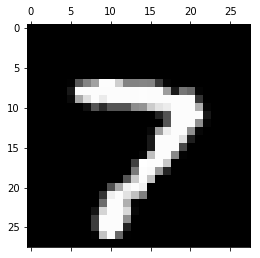

In [11]:
plt.matshow(np.uint8(x_test[index]).reshape(28,28), cmap=plt.cm.gray)
plt.show()

In [12]:
# 預測輸出結果
y = predict(network,x_test_2[index])
np.argmax(y)

7

In [13]:
%time
batch_size = 100
accuracy_cnt = 0
for i in range(0,len(x_test),batch_size):
    x_batch = x_test_2[i:i+batch_size]
    y_batch = predict(network,x_batch)
    p = np.argmax(y_batch,axis =1)
    accuracy_cnt += np.sum(p == t_test[i:i+batch_size])
print("Accuracy:%f"%(float(accuracy_cnt)/len(x_test_2)))

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 8.11 µs
Accuracy:0.932219


In [171]:
def mean_squared_error(y,t):
    return 0.5 * np.sum((y-t)**2)

def cross_entropy_error(y,t):
    delta = 1e-7
    return -np.sum(t*np.log(y+delta))

def one_hot_label(y,size):
    a = np.zeros([y.shape[0],size])
    for i in range(y.shape[0]):
        a[i,int(y[i])] = 1
    return a

In [ ]:
b = one_hot_label(t_test,10)
b.shape

In [18]:
train = x_test/256
test = t_test
train_size = train.shape[0]
batch_size = 10
# 最後選出的資料集
batch_mask = np.random.choice(train_size,batch_size)
x_batch = train[batch_mask]
t_batch = train[batch_mask]

In [19]:
# one_hot_vector version
def cross_entorpy_error(y,t):
    if y.ndim == 1:
        t = t.reshape(1,t.size)
        y = y.reshape(1,y.size)
    batch_size = y.shape[0]
    return -np.sum(t*np.log(y))/batch_size

In [91]:
def numerical_diff(f,x):
    h = 1e-4 # 容許在float32底下運作
    return (f(x+h)-f(x-h))/(2*h)

def function_2(x):
    return np.sum(x**2)

# https://github.com/oreilly-japan/deep-learning-from-scratch/blob/master/common/gradient.py
def numerical_gradient(f,x):
    h = 1e-4
    grad = np.zeros_like(x)
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        idx = it.multi_index
        tmp_val = x[idx]
        x[idx] = float(tmp_val)+h
        fxh1= f(x)
        
        x[idx] = float(tmp_val)-h
        fxh2= f(x)
        
        grad[idx] = (fxh1 - fxh2) / (2*h)
        x[idx] = tmp_val
        it.iternext() 
    return grad

def gradient_descent(f,init_x,lr=0.01,step_num = 100):
    x = init_x
    for i in range(step_num):
        grad = numerical_gradient(f,x)
        x -= lr * grad
    return x

驗證day3 都可以運作

In [73]:
init_x = np.array([-3.0,4.0])
gradient_descent(function_2,init_x=init_x,lr=0.1,step_num=100)

array([-6.11110793e-10,  8.14814391e-10])

### 開始學習

$$ \bf{W} = 
  \begin{pmatrix}
    w_{11} & w_{21} & w_{31} \\
    w_{12} & w_{22} & w_{32} 
  \end{pmatrix} $$

$$ \frac{\partial L}{\partial \bf{W}} = 
  \begin{pmatrix}
    \frac{\partial L}{\partial w_{11}} &     \frac{\partial L}{\partial w_{21}} &     \frac{\partial L}{\partial w_{31}} \\
\frac{\partial L}{\partial w_{12}} &     \frac{\partial L}{\partial w_{22}} &     \frac{\partial L}{\partial w_{32}} 
  \end{pmatrix} $$


建立簡單神經網路

In [52]:
class SimpleNet:
    def __init__(self):
        #self.W = np.random.rand(2,3) ## 以常態分佈初始化
        self.W = np.array([[0.47355232,0.9977393,0.84668094],
       [0.85557411,0.03563661,0.69422093]])
    def predict(self,x):
        return np.dot(x,self.W)
    def loss(self,x,t):
        z = self.predict(x)
        y = softmax(z)
        loss = cross_entorpy_error(y,t)
        return loss
net = SimpleNet()

In [37]:
net.W

array([[0.47355232, 0.9977393 , 0.84668094],
       [0.85557411, 0.03563661, 0.69422093]])

In [68]:
x = np.array([0.6,0.9])
p = net.predict(x)
p

array([1.05414809, 0.63071653, 1.1328074 ])

In [69]:
np.argmax(p)

2

In [92]:
t = np.array([0,0,1])
net.loss(x,t)

0.9281123899431699

In [96]:
# 要留意這裡有目標數值也要帶入 t
def f(W):
    t = np.array([0,0,1])
    return net.loss(x,t)
f = lambda w : net.loss(x,t) #另外一種寫法, 感覺不怎麼好用
dW = numerical_gradient(f,net.W)
dW

array([[ 0.21928102,  0.14354988, -0.36283089],
       [ 0.32892153,  0.21532481, -0.54424634]])

### 執行學習演算法 stochastic gradient descent, SGD
1. 小批次選取資料
2. 計算梯度
3. 更新資料
4. 重複執行

In [179]:
class TwoLayerNet:
    def __init__(self,input_size,hidden_size,output_size,weight_init_std=0.01):
        self.params = {}
        self.params['W1'] = weight_init_std* np.random.randn(input_size,hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std* np.random.randn(hidden_size,output_size)
        self.params['b2'] = np.zeros(output_size)
        
        
    def predict(self,x):
        W1,W2 = self.params['W1'],self.params['W2']
        b1,b2 = self.params['b1'],self.params['b2']        
        
        a1 = np.dot(x,W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1,W2) + b2
        z2 = sigmoid(a2)
        y = softmax(z2)
        
        return y
    
    
    def loss(self,x,t):
        y = self.predict(x)
        return cross_entorpy_error(y,t)
    
    
    def accuracy(self,x,t):
        y = self.predict(x)
        y = np.argmax(y,axis=1)
        t = np.argmax(t,axis=1)
        accuracy = np.sum(y==t) / float(x.shape[0])
        return accuracy
    
    def numerical_gradient(self,x,t):
        loss_w = lambda W: self.loss(x,t)
        grads = {}
        grads["W1"] = numerical_gradient(loss_w,self.params['W1'])
        grads["W2"] = numerical_gradient(loss_w,self.params['W2'])
        grads["b1"] = numerical_gradient(loss_w,self.params['b1'])
        grads["b2"] = numerical_gradient(loss_w,self.params['b1'])
        return grads

    #額外增加的
    def gradient(self, x, t):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
        grads = {}
        
        batch_num = x.shape[0]
        
        # forward
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)
        
        # backward
        dy = (y - t) / batch_num
        grads['W2'] = np.dot(z1.T, dy)
        grads['b2'] = np.sum(dy, axis=0)
        
        da1 = np.dot(dy, W2.T)
        dz1 = sigmoid_grad(a1) * da1
        grads['W1'] = np.dot(x.T, dz1)
        grads['b1'] = np.sum(dz1, axis=0)

        return grads
    
#為了加速增加的
def sigmoid_grad(x):
    return (1.0 - sigmoid(x)) * sigmoid(x)

In [128]:
net = TwoLayerNet(input_size=784,hidden_size=100,output_size=10)

In [129]:
net.params['W1'].shape

(784, 100)

In [122]:
x = np.random.rand(100,784)
t = np.random.rand(100,10)
y = net.predict(x)

In [123]:
np.argmax(t,axis=1)

array([8, 6, 3, 7, 5, 6, 9, 3, 6, 2, 0, 0, 1, 7, 3, 7, 9, 0, 6, 6, 0, 5,
       7, 2, 8, 1, 3, 5, 4, 6, 0, 8, 2, 4, 6, 5, 9, 7, 6, 9, 2, 6, 7, 1,
       3, 4, 2, 7, 5, 7, 4, 4, 5, 2, 0, 2, 8, 3, 1, 7, 5, 4, 7, 0, 9, 3,
       7, 3, 7, 5, 9, 4, 1, 3, 4, 9, 5, 5, 2, 3, 8, 1, 5, 4, 3, 9, 6, 9,
       9, 5, 0, 1, 3, 3, 4, 6, 6, 8, 6, 3])

In [132]:
%time
gards = net.numerical_gradient(x,t)
gards

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 24.1 µs


{'W1': array([[-8.73697559e-06,  2.89258040e-05, -1.80842363e-05, ...,
         -2.39813502e-05, -3.41557893e-05,  6.51987264e-05],
        [-1.27692346e-05,  2.93646707e-05,  1.53818291e-05, ...,
          1.68904180e-05,  2.31185737e-06,  6.87698787e-06],
        [-8.73320971e-06,  5.56524427e-05, -6.78891610e-06, ...,
          3.33823635e-05, -1.36103750e-05,  5.48535084e-05],
        ...,
        [-2.22672725e-05,  6.97226454e-05,  2.52012811e-05, ...,
          4.86891238e-05, -1.22861721e-05,  1.34388856e-05],
        [-1.18358301e-05,  4.18496526e-05,  4.51677806e-06, ...,
          1.86510363e-06, -7.36964267e-06,  3.75082010e-05],
        [-1.82954096e-05,  3.75345266e-05,  9.44382350e-07, ...,
          3.39785089e-06, -5.56887869e-07,  3.17466231e-05]]),
 'W2': array([[ 3.06700507e-03,  4.91763540e-03,  2.97869249e-04,
         -4.71028621e-03, -1.82774080e-03,  1.54383990e-04,
         -4.77097473e-05,  2.67426746e-03, -2.30044822e-03,
         -2.76438637e-03],
        [ 

## 執行小批次學習

In [131]:
gards = net.gradient(x,t)
gards

{'W1': array([[ 3.96943168e-05,  2.65811455e-04, -2.07106930e-03, ...,
         -1.68227579e-03, -1.46975585e-03,  1.97589136e-03],
        [ 3.02439888e-05,  2.80991004e-04, -2.11397352e-03, ...,
         -1.65866764e-03, -1.44191173e-03,  1.89394567e-03],
        [ 4.80666745e-05,  3.89544991e-04, -2.24893973e-03, ...,
         -1.62999128e-03, -1.53731220e-03,  2.12651090e-03],
        ...,
        [ 1.20072459e-06,  4.60504606e-04, -2.31594835e-03, ...,
         -1.72337192e-03, -1.66112567e-03,  2.12767889e-03],
        [ 4.13308893e-05,  3.45733676e-04, -2.35789668e-03, ...,
         -1.87625791e-03, -1.61333643e-03,  2.18701532e-03],
        [ 7.45120805e-06,  3.12423669e-04, -2.15619644e-03, ...,
         -1.70001652e-03, -1.44196046e-03,  1.97910400e-03]]),
 'W2': array([[-0.2212197 , -0.22003496, -0.23655291, -0.25662745, -0.24141125,
         -0.23457678, -0.23696842, -0.22688089, -0.24233266, -0.24323878],
        [-0.22334808, -0.22314552, -0.23858839, -0.25947246, -0.2439

In [217]:
def fix(x_train,t_train,x_test,t_test):    
    return x_train/255.0,one_hot_label(t_train,10),x_test/255.0,one_hot_label(t_test,10)
#修改輸入的值 preprocessing
(x_train,t_train,x_test,t_test) = load_data(10000)
(x_train_aha,t_train_aha,x_test_aha,t_test_aha) = fix(x_train,t_train,x_test,t_test)
print(x_train_aha.shape)
print(t_train_aha.shape)
print(x_test_aha.shape)
print(t_test_aha.shape)

(10000, 784)
(10000, 10)
(60000, 784)
(60000, 10)


In [138]:
#保存紀錄訓練狀況
train_loss_list = []

In [143]:
# meta parameter
iters_num = 10000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

In [222]:
network = TwoLayerNet(input_size=784,hidden_size=50,output_size=10)

In [147]:
for i in range(iters_num):
    batch_mask = np.random.choice(train_size,batch_size)
    x_batch = x_train_aha[batch_mask]
    t_batch = t_train_aha[batch_mask]
    
    #計算梯度
    #grad = network.numerical_gradient(x_batch,t_batch) 好慢啊
    grad = network.gradient(x_batch,t_batch)
    
    for key in ('W1','b1','W2','b2'):
        network.params[key] -= learning_rate * grad[key]
    
    loss = network.loss(x_batch,t_batch)
    train_loss_list.append(loss)

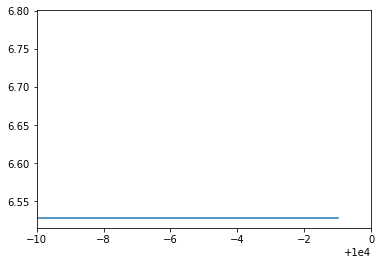

In [152]:
plt.plot(train_loss_list)
plt.xlim(9990,10000)
plt.show()

## 用測試資料做評估
epoch 定義為，假設每次小批次訓練為100, 整體資料數量為10000。那表示每使用100次小批次訓練就能看完所有資料集。這時候 1 epoch = 100


In [223]:
train_acc_list = [] 
test_acc_list = []
train_loss_list = []
iter_per_epoch = max(train_size/batch_size,1)

In [224]:
for i in range(iters_num):
    batch_mask = np.random.choice(train_size,batch_size)
    x_batch = x_train_aha[batch_mask]
    t_batch = t_train_aha[batch_mask]
    
    #計算梯度
    #grad = network.numerical_gradient(x_batch,t_batch) 好慢啊
    grad = network.gradient(x_batch,t_batch)
    
    for key in ('W1','b1','W2','b2'):
        network.params[key] -= learning_rate * grad[key]
    
    loss = network.loss(x_batch,t_batch)
    train_loss_list.append(loss)
    
    if i % iter_per_epoch == 0 :
        train_acc = network.accuracy(x_train_aha,t_train_aha)
        test_acc = network.accuracy(x_test_aha,t_test_aha)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print("train acc, test acc | %f , %f"%(train_acc,test_acc) )

train acc, test acc | 0.092300 , 0.089833
train acc, test acc | 0.113600 , 0.112500
train acc, test acc | 0.220900 , 0.215367
train acc, test acc | 0.477600 , 0.482417
train acc, test acc | 0.666200 , 0.669500
train acc, test acc | 0.736500 , 0.737350
train acc, test acc | 0.793800 , 0.793483
train acc, test acc | 0.815400 , 0.820333
train acc, test acc | 0.838100 , 0.842300
train acc, test acc | 0.853000 , 0.855433
train acc, test acc | 0.861700 , 0.864050
train acc, test acc | 0.872600 , 0.872450
train acc, test acc | 0.882100 , 0.878083
train acc, test acc | 0.887200 , 0.883900
train acc, test acc | 0.888600 , 0.886317
train acc, test acc | 0.893600 , 0.888567
train acc, test acc | 0.895900 , 0.892367
train acc, test acc | 0.897300 , 0.893383
train acc, test acc | 0.899400 , 0.896100
train acc, test acc | 0.903300 , 0.898283
train acc, test acc | 0.905200 , 0.899767
train acc, test acc | 0.906800 , 0.902150
train acc, test acc | 0.908800 , 0.903267
train acc, test acc | 0.910600 , 0

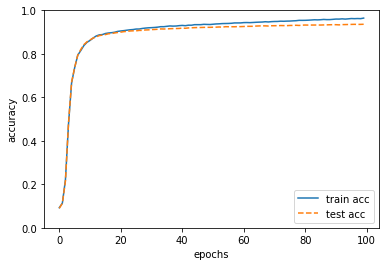

In [225]:
#https://github.com/oreilly-japan/deep-learning-from-scratch/blob/master/ch04/train_neuralnet.py
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, label='train acc')
plt.plot(x, test_acc_list, label='test acc', linestyle='--')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()